<a href="https://colab.research.google.com/github/on-kulyashov/Code-for-NMR-course/blob/main/Wigner_Dyson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

pauli = np.array([ [[0,1],[1,0]], [[0,-1j],[1j,0]], [[1,0],[0,-1]] ]) / 2
dbl_pauli = np.array([np.kron(a,a) for a in pauli])

bin_num = 20
length = 6
trials = 50
mag_treshold = 0.1 * length
S_z = pauli[2]
for i in range(length-1):
    S_z = np.kron(S_z, pauli[2])

def magnet(v):
    return np.matmul(np.transpose(v), np.matmul(S_z, v))

# hamiltonian construction
def Hamiltonian(hz, N):
    H = np.zeros(2**N)
    H = H + np.kron(np.kron(pauli[2], np.eye(2**(N-2))), pauli[2])
    H = H + np.kron(np.kron(pauli[1], np.eye(2**(N-2))), pauli[1])
    H = H + np.kron(np.kron(pauli[0], np.eye(2**(N-2))), pauli[0])
    for i in range(N-1):
        H = H + np.kron(np.kron(np.eye(2**i), dbl_pauli[2]), np.eye(2**(N-2-i)))
        H = H + np.kron(np.kron(np.eye(2**i), dbl_pauli[1]), np.eye(2**(N-2-i)))
        H = H + np.kron(np.kron(np.eye(2**i), dbl_pauli[0]), np.eye(2**(N-2-i)))
    for i in range(N):
        H = H + hz[i]*np.kron(np.kron(np.eye(2**i), pauli[2]), np.eye(2**(N-1-i)))
    return np.real_if_close(H)

# stats collection
def stat(disorder, length, trials):
    kl_div = []
    p_r = []
    r_mean = 0
    for i in range(trials):
        hz = np.random.uniform(-disorder, disorder, length)
        H = Hamiltonian(hz, length)
        H, V = np.linalg.eig(H)
        E = np.real_if_close(H)
        idx = np.argsort(E)
        E = E[idx]
        V = V[:,idx]
        Esym = []
        Vsym = []
        for k in range(len(E)):
            if magnet(V[k]) < mag_treshold:
                Esym.append(E[k])
                Vsym.append(V[k])
        Esym = np.array(Esym)
        Vsym = np.array(Vsym)
        s = Esym[1:] - Esym[:-1]
        r = [min(s[j],s[j+1]) / max(s[j], s[j+1]) for j in range(len(s) - 1)]
        if i == 0:
            p_r = list(np.histogram(r, bins=bin_num,range=(0,1), density=True))
        else:
            p_r_temp = np.histogram(r, bins=bin_num,range=(0,1), density=True)
            p_r[0] = p_r[0] + p_r_temp[0]
        entr = np.array([entropy(abs(Vsym[:,j])**2, abs(Vsym[:,j+1])**2)  for j in range(1,len(E) - 2)])
        kl_div.append(np.mean(entr[entr < 1E308]))
        r_mean += np.mean(r)
    p_r[0] = p_r[0] / trials
    p_r[1] = p_r[1]
    r_mean = r_mean / trials
    return (r_mean, p_r, kl_div)


# plotting
disorder = [0.1,0.3, 0.5] 
r_mean_array = []
kl_div_mean_array = []
p_r_array = []
for dis in disorder:
    stats = stat(dis, length, trials)
    r_mean_array.append(stats[0])
    kl_div_mean_array.append(stats[2])
    p_r_array.append(stats[1])

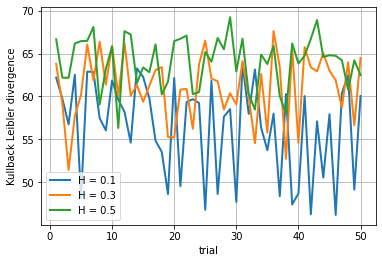

In [11]:
leg = []
for dis in disorder:
    leg.append("H = {}".format(dis))
for kl_div_mean_ar in kl_div_mean_array:
    plt.plot(np.linspace(1, trials, trials), kl_div_mean_ar, linewidth=2.0)
plt.xlabel("trial")
plt.ylabel("Kullback Leibler divergence")
plt.legend(leg)
plt.grid()
plt.show()

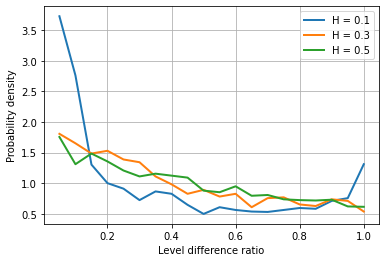

In [9]:
leg = []
for dis in disorder:
    leg.append("H = {}".format(dis))
for p_r_ar in p_r_array:
    plt.plot(p_r_ar[1][1:], p_r_ar[0], linewidth=2.0)
plt.xlabel("Level difference ratio")
plt.ylabel("Probability density")
plt.legend(leg)
plt.grid()
plt.show()

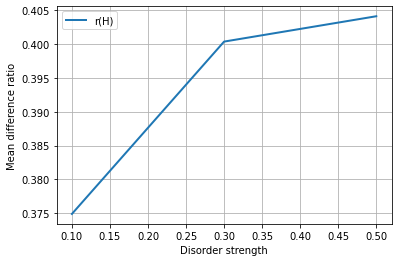

In [12]:
plt.plot(disorder, r_mean_array, linewidth=2.0)
plt.xlabel("Disorder strength")
plt.ylabel("Mean difference ratio")
plt.legend(["r(H)"])
plt.grid()
plt.show()